In [1]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 作業フォルダへの移動を行います。
# 人によって作業場所が異なるので、その場合作業場所を変更してください。
import os
os.chdir('/content/drive/MyDrive/コンペ/参加中コンペ') #ここを変更。

In [3]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submit.csv',index_col=0, header=None)
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,200,9,125,74,0,0,28.536910,0.444902,45,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0
4,3644,5,107,78,44,284,52.935068,0.284959,45,1


In [4]:
test.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,398,0,126,80,0,0,40.096264,0.822517,21
1,3833,3,88,60,20,0,39.810590,0.204331,22
2,4836,3,114,76,0,0,33.198760,0.521011,21
3,4572,1,146,74,0,0,26.890259,0.504950,38
4,636,1,123,90,26,140,40.270088,0.800513,28


In [5]:
sample.head()

,1
0,
398,0
3833,0
4836,0
4572,0
636,0


In [11]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.262073,0.400476,28.932000,0.239000
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,7.568025,0.274666,8.469078,0.426544
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000775,0.145844,21.000000,0.000000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000


In [24]:
diabetes=train[train["Outcome"]==1]
no_diabetes=train[train["Outcome"]==0]

In [27]:
len(diabetes)

717

In [26]:
len(no_diabetes)

2283

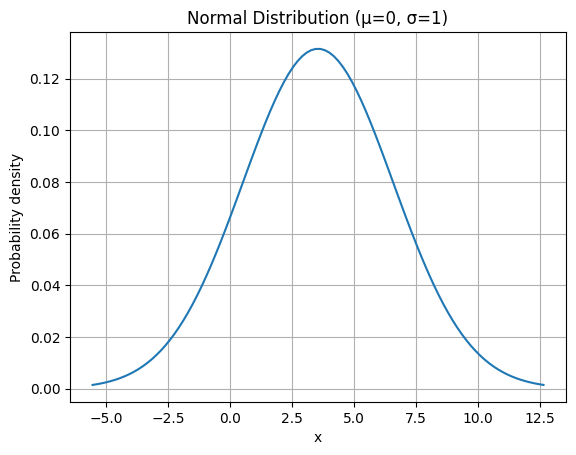

In [45]:
import numpy as np
# 平均値と標準偏差を指定
mu = train['Pregnancies'].mean()
sigma = train['Pregnancies'].std()

# X軸の値を生成
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# 正規分布の確率密度関数を計算
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# 正規分布をプロット
plt.plot(x, y)
plt.title('Normal Distribution (μ=0, σ=1)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

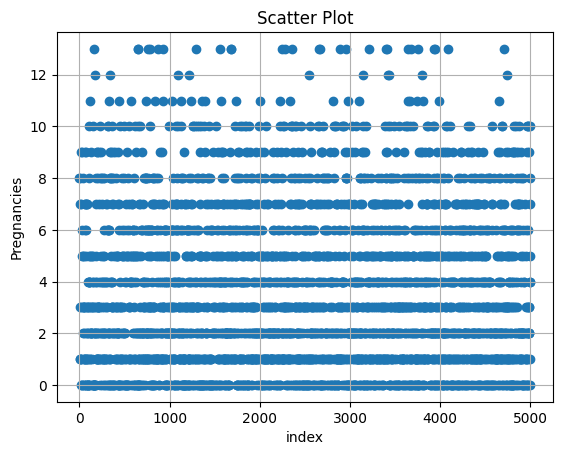

In [12]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['Pregnancies'])
plt.xlabel('index')
plt.ylabel('Pregnancies')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

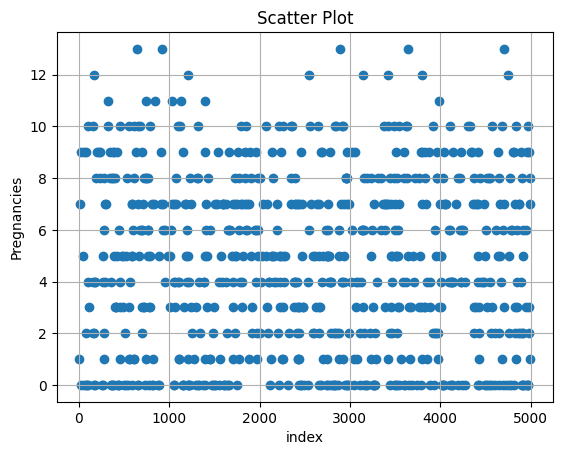

In [28]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['Pregnancies'])
plt.xlabel('index')
plt.ylabel('Pregnancies')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

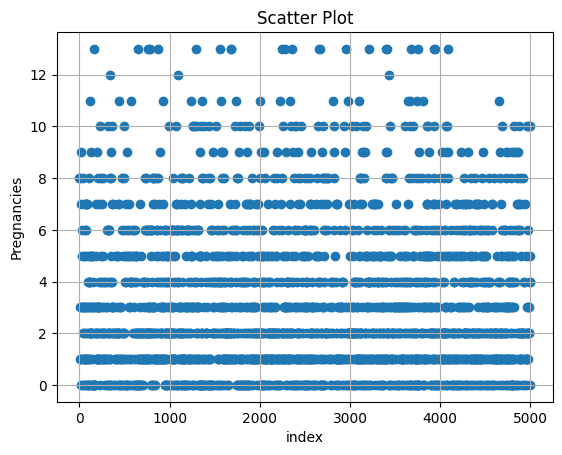

In [29]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['Pregnancies'])
plt.xlabel('index')
plt.ylabel('Pregnancies')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

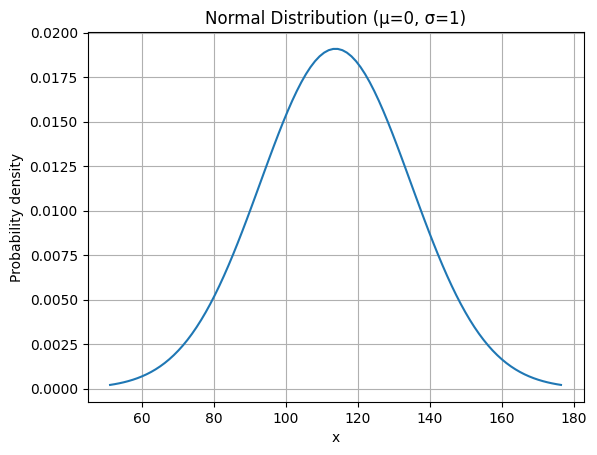

In [46]:
import numpy as np
# 平均値と標準偏差を指定
mu = train['Glucose'].mean()
sigma = train['Glucose'].std()

# X軸の値を生成
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# 正規分布の確率密度関数を計算
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# 正規分布をプロット
plt.plot(x, y)
plt.title('Normal Distribution (μ=0, σ=1)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

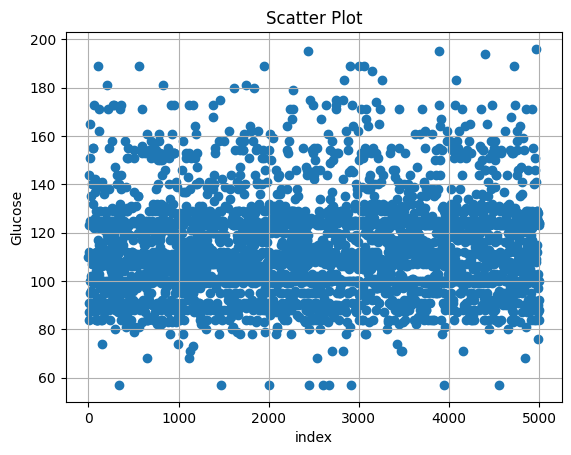

In [13]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['Glucose'])
plt.xlabel('index')
plt.ylabel('Glucose')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

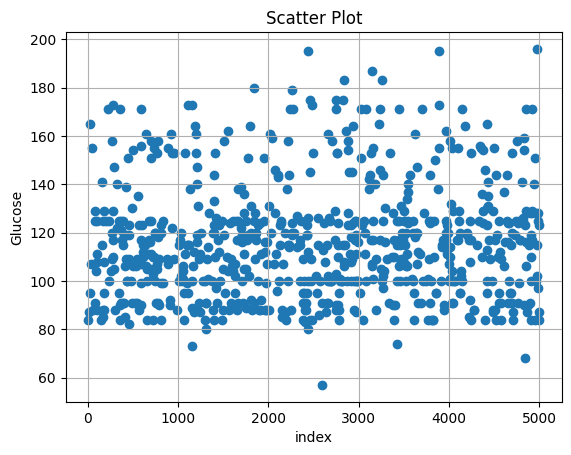

In [30]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['Glucose'])
plt.xlabel('index')
plt.ylabel('Glucose')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

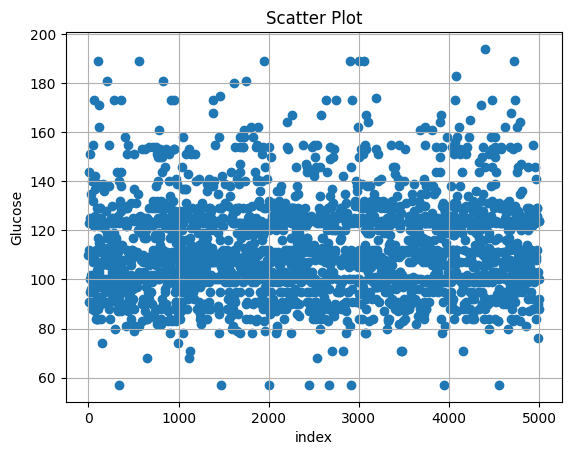

In [31]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['Glucose'])
plt.xlabel('index')
plt.ylabel('Glucose')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

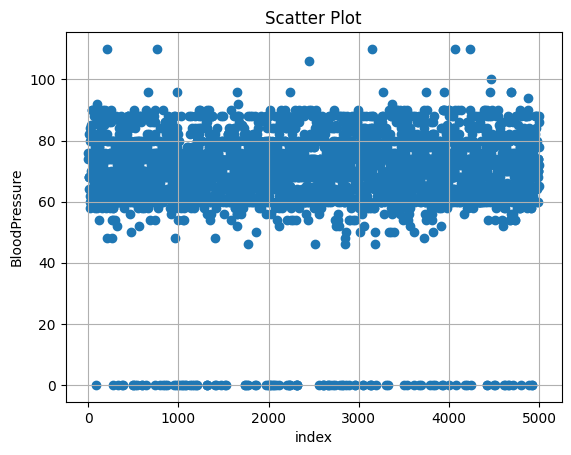

In [15]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['BloodPressure'])
plt.xlabel('index')
plt.ylabel('BloodPressure')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

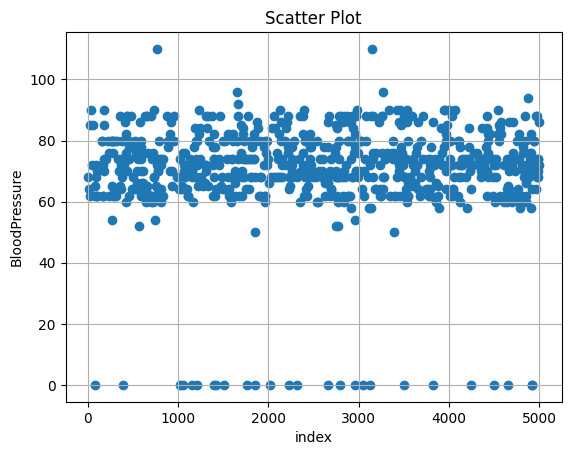

In [32]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['BloodPressure'])
plt.xlabel('index')
plt.ylabel('BloodPressure')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

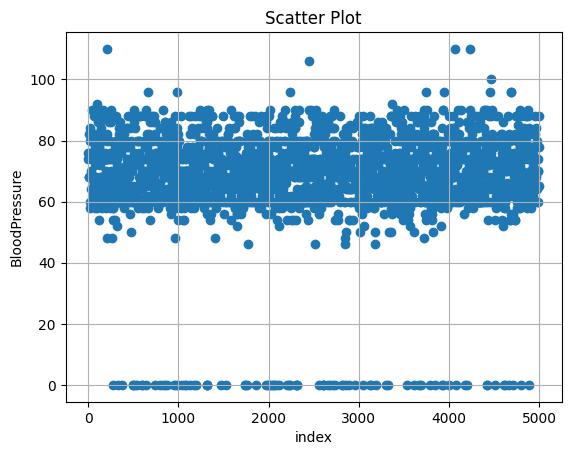

In [33]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['BloodPressure'])
plt.xlabel('index')
plt.ylabel('BloodPressure')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

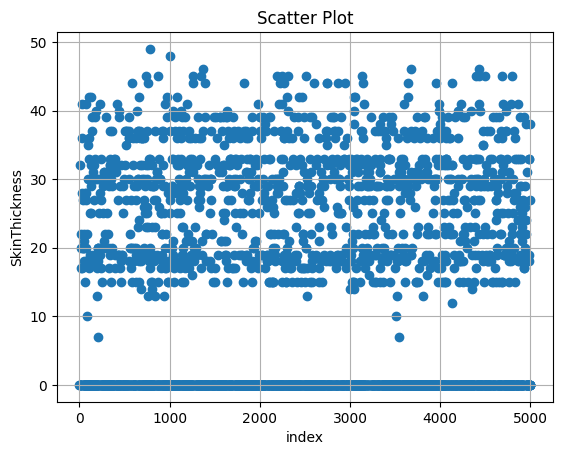

In [16]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['SkinThickness'])
plt.xlabel('index')
plt.ylabel('SkinThickness')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

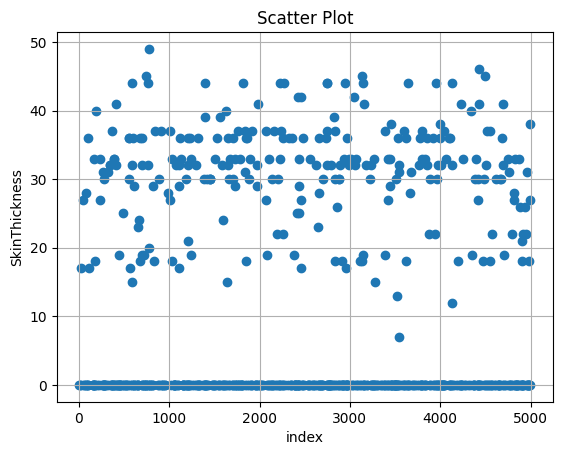

In [35]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['SkinThickness'])
plt.xlabel('index')
plt.ylabel('SkinThickness')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

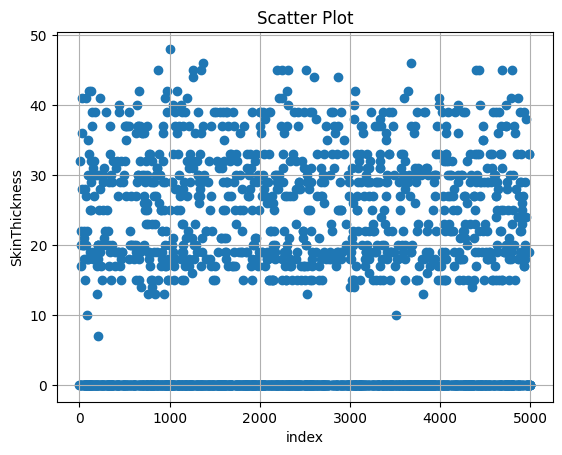

In [34]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['SkinThickness'])
plt.xlabel('index')
plt.ylabel('SkinThickness')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

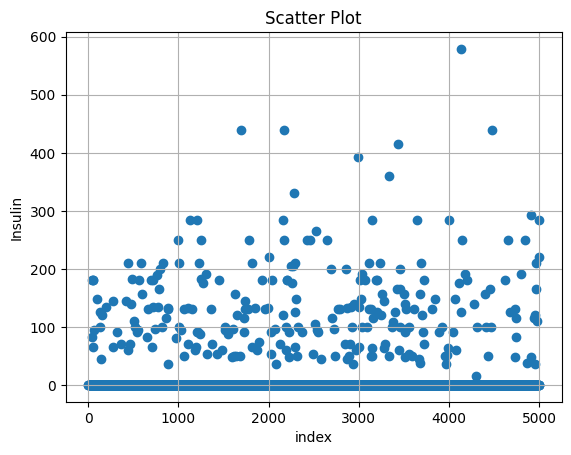

In [17]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['Insulin'])
plt.xlabel('index')
plt.ylabel('Insulin')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

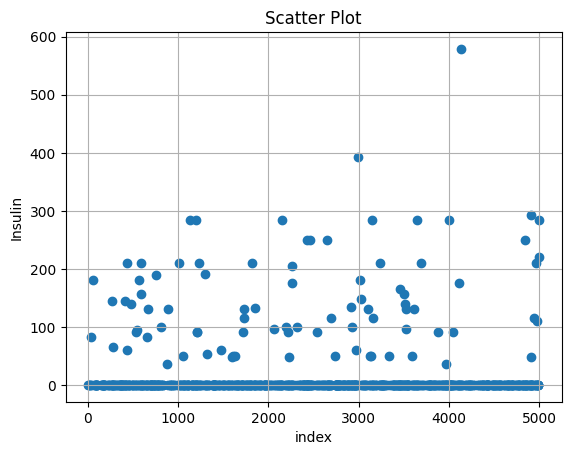

In [36]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['Insulin'])
plt.xlabel('index')
plt.ylabel('Insulin')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

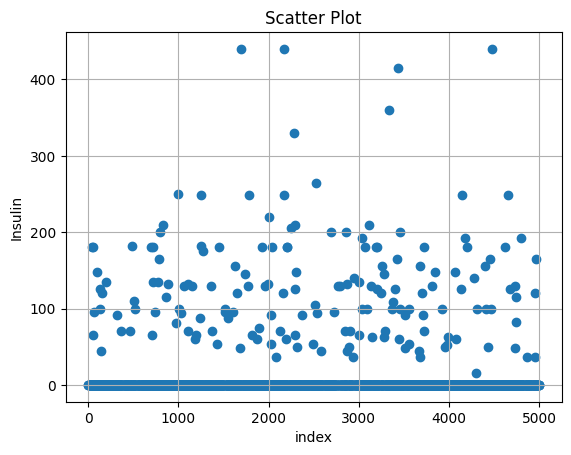

In [37]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['Insulin'])
plt.xlabel('index')
plt.ylabel('Insulin')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

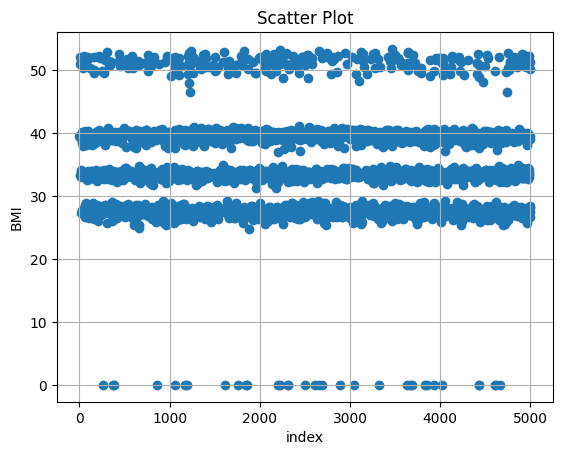

In [18]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['BMI'])
plt.xlabel('index')
plt.ylabel('BMI')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

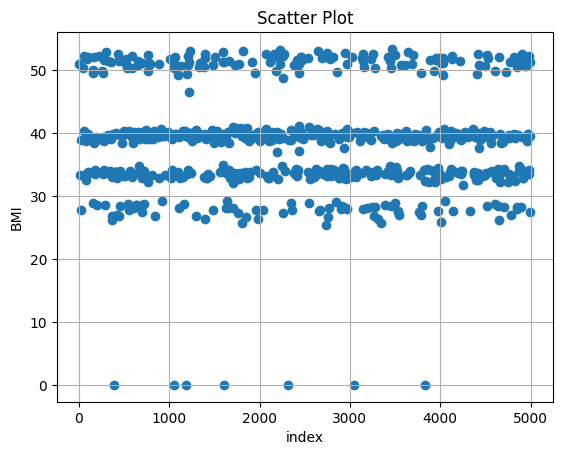

In [38]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['BMI'])
plt.xlabel('index')
plt.ylabel('BMI')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

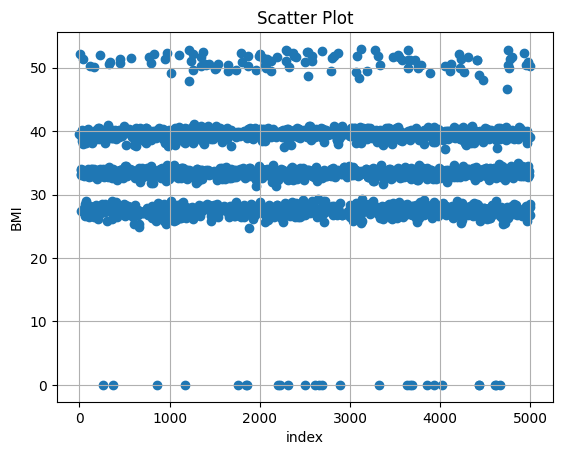

In [39]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['BMI'])
plt.xlabel('index')
plt.ylabel('BMI')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

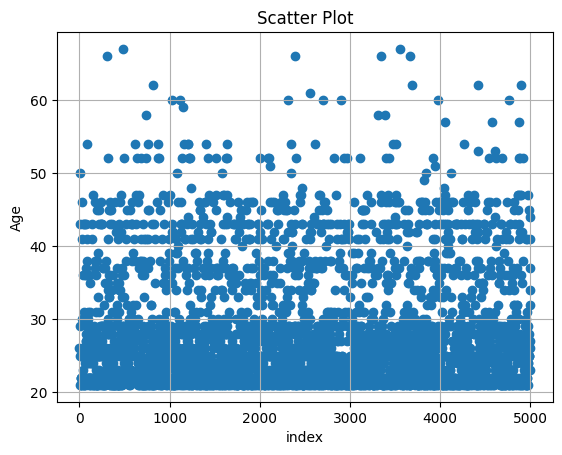

In [19]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['Age'])
plt.xlabel('index')
plt.ylabel('Age')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

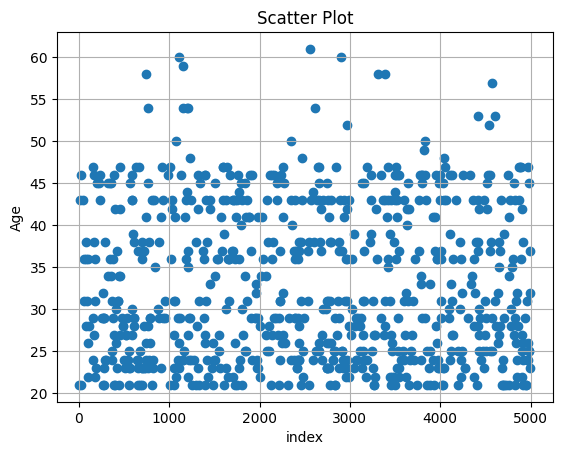

In [40]:
import matplotlib.pyplot as plt
plt.scatter(diabetes['index'], diabetes['Age'])
plt.xlabel('index')
plt.ylabel('Age')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

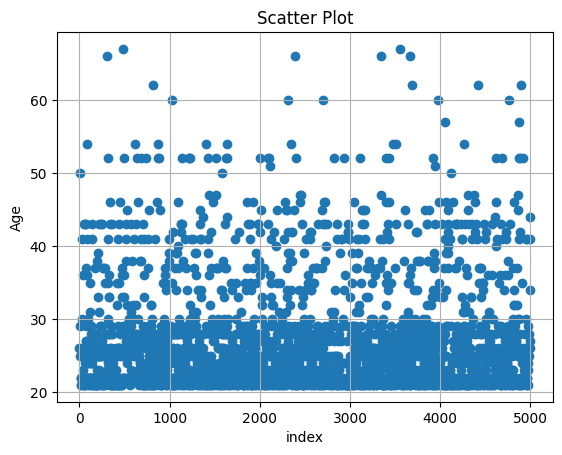

In [41]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['Age'])
plt.xlabel('index')
plt.ylabel('Age')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

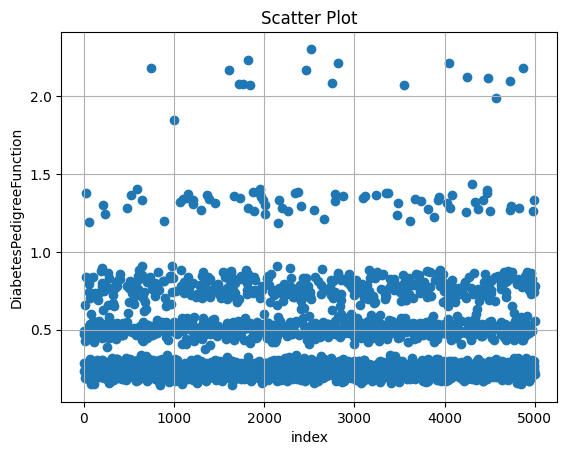

In [20]:
import matplotlib.pyplot as plt
plt.scatter(train['index'], train['DiabetesPedigreeFunction'])
plt.xlabel('index')
plt.ylabel('DiabetesPedigreeFunction')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

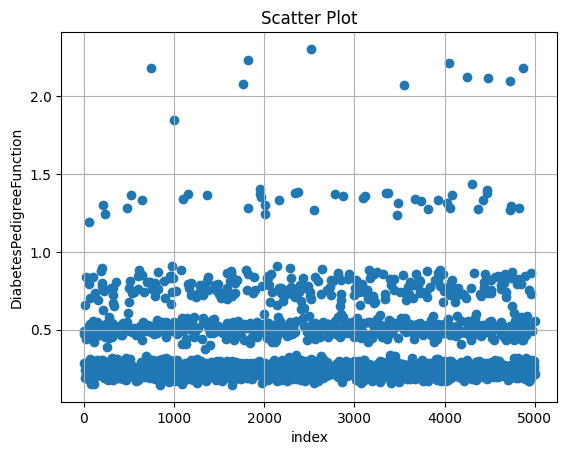

In [42]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['DiabetesPedigreeFunction'])
plt.xlabel('index')
plt.ylabel('DiabetesPedigreeFunction')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

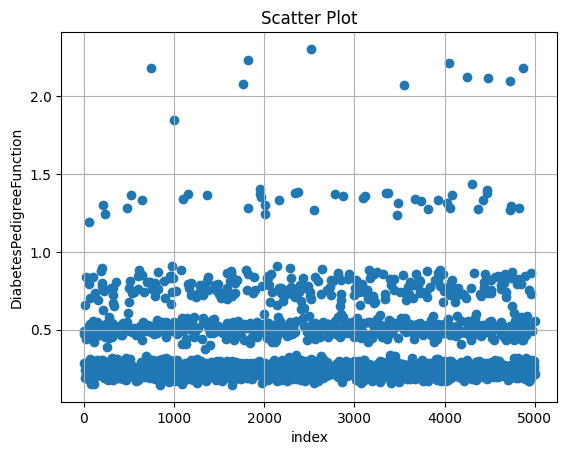

In [43]:
import matplotlib.pyplot as plt
plt.scatter(no_diabetes['index'], no_diabetes['DiabetesPedigreeFunction'])
plt.xlabel('index')
plt.ylabel('DiabetesPedigreeFunction')
plt.title('Scatter Plot')
plt.grid(True)  # グリッドを表示する
plt.show()

In [21]:
train_x=train.drop(["Outcome"],axis=1)
train_y=train["Outcome"]
test_x = test.copy()

In [22]:
train_x = train_x.drop(["index"],axis=1)
test_x = test_x.drop(["index"],axis=1)

In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss , accuracy_score
import xgboost as xgb
from sklearn.metrics import log_loss
import numpy as np
from sklearn.metrics import log_loss , accuracy_score

scores_accuracy = []
scores_logloss =[]
#クロスバリデーションを行う
#学習データを4分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf=KFold(n_splits=4 , shuffle=True , random_state = 71)
for tr_idx,va_idx in kf.split(train_x):
  #学習データを学習データとバリデーションデータに分ける
  tr_x,va_x=train_x.iloc[tr_idx],train_x.iloc[va_idx]
  tr_y,va_y=train_y.iloc[tr_idx],train_y.iloc[va_idx]
  #特徴量と目的変数をxgboostのデータ構造に変換する
  dtrain = xgb.DMatrix(tr_x,label=tr_y)
  dvalid = xgb.DMatrix(va_x, label = va_y)
  dtest = xgb.DMatrix(test_x)
  #ハイパーパラメータの設定
  #silent:1によってが学習中のメッセージを抑制するようになっている
  #random_stateをせっていすることによって再現性を保つことが出来るようにしている。
  params = {"objective": "binary:logistic","silent":1,"random_state":71}
  num_round = 50;

  watchlist = [(dtrain,"train"),(dvalid,"eval")]
  model = xgb.train(params,dtrain,num_round,evals=watchlist)

  va_pred = model.predict(dvalid)
  #loglossはロジスティック損失を表しており、ロジスティック損失は、確率予測の正確さを測るための指標のひとつで、誤差が大きいほど損失が指数関数的に大きくなる特徴があります。
  score = log_loss(va_y,va_pred)
  accuracy = accuracy_score(va_y,va_pred>0.5)
  scores_logloss.append(score)
  scores_accuracy.append(accuracy)

print(f"logloss:{np.mean(scores_logloss):.4f}")
print(f"accuracy:{np.mean(scores_accuracy):.4f}")

pred = model.predict(dtest)
pred_label=np.where(pred>0.5,1,0)


[0]	train-logloss:0.48523	eval-logloss:0.51008
[1]	train-logloss:0.43894	eval-logloss:0.48637
[2]	train-logloss:0.41061	eval-logloss:0.46926
[3]	train-logloss:0.38745	eval-logloss:0.45673
[4]	train-logloss:0.36352	eval-logloss:0.44576
[5]	train-logloss:0.34882	eval-logloss:0.44179
[6]	train-logloss:0.33344	eval-logloss:0.44100
[7]	train-logloss:0.32050	eval-logloss:0.43882
[8]	train-logloss:0.30989	eval-logloss:0.43906
[9]	train-logloss:0.30370	eval-logloss:0.43856
[10]	train-logloss:0.29270	eval-logloss:0.43743
[11]	train-logloss:0.28553	eval-logloss:0.43529
[12]	train-logloss:0.27885	eval-logloss:0.43607
[13]	train-logloss:0.27409	eval-logloss:0.43485
[14]	train-logloss:0.26410	eval-logloss:0.43446
[15]	train-logloss:0.25680	eval-logloss:0.43374
[16]	train-logloss:0.25170	eval-logloss:0.43329
[17]	train-logloss:0.24278	eval-logloss:0.43192
[18]	train-logloss:0.23803	eval-logloss:0.43410
[19]	train-logloss:0.23409	eval-logloss:0.43337
[20]	train-logloss:0.23036	eval-logloss:0.43231
[2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:33:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	train-logloss:0.16664	eval-logloss:0.45014
[36]	train-logloss:0.16010	eval-logloss:0.44805
[37]	train-logloss:0.15645	eval-logloss:0.44897
[38]	train-logloss:0.15496	eval-logloss:0.44918
[39]	train-logloss:0.15261	eval-logloss:0.44770
[40]	train-logloss:0.15169	eval-logloss:0.44795
[41]	train-logloss:0.15005	eval-logloss:0.44992
[42]	train-logloss:0.14661	eval-logloss:0.45034
[43]	train-logloss:0.14394	eval-logloss:0.45167
[44]	train-logloss:0.14271	eval-logloss:0.45256
[45]	train-logloss:0.14125	eval-logloss:0.45143
[46]	train-logloss:0.14013	eval-logloss:0.45117
[47]	train-logloss:0.13902	eval-logloss:0.45132
[48]	train-logloss:0.13576	eval-logloss:0.45407
[49]	train-logloss:0.13262	eval-logloss:0.45279
[0]	train-logloss:0.49401	eval-logloss:0.48788
[1]	train-logloss:0.44819	eval-logloss:0.46798
[2]	train-logloss:0.41844	eval-logloss:0.45648
[3]	train-logloss:0.39605	eval-logloss:0.44810
[4]	train-logloss:0.37637	eval-logloss:0.44209
[5]	train-logloss:0.36085	eval-logloss:0.4395

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:33:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	train-logloss:0.18315	eval-logloss:0.45045
[34]	train-logloss:0.18035	eval-logloss:0.45334
[35]	train-logloss:0.17791	eval-logloss:0.45218
[36]	train-logloss:0.17624	eval-logloss:0.45375
[37]	train-logloss:0.17507	eval-logloss:0.45349
[38]	train-logloss:0.17323	eval-logloss:0.45524
[39]	train-logloss:0.16829	eval-logloss:0.45769
[40]	train-logloss:0.16317	eval-logloss:0.46055
[41]	train-logloss:0.16155	eval-logloss:0.46099
[42]	train-logloss:0.15886	eval-logloss:0.46100
[43]	train-logloss:0.15812	eval-logloss:0.46139
[44]	train-logloss:0.15495	eval-logloss:0.46199
[45]	train-logloss:0.15390	eval-logloss:0.46171
[46]	train-logloss:0.14849	eval-logloss:0.46449
[47]	train-logloss:0.14562	eval-logloss:0.46506
[48]	train-logloss:0.14271	eval-logloss:0.46489
[49]	train-logloss:0.14105	eval-logloss:0.46689
[0]	train-logloss:0.48694	eval-logloss:0.50006
[1]	train-logloss:0.44780	eval-logloss:0.47783
[2]	train-logloss:0.41648	eval-logloss:0.46409
[3]	train-logloss:0.39364	eval-logloss:0.45

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:33:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	train-logloss:0.18702	eval-logloss:0.42013
[32]	train-logloss:0.18552	eval-logloss:0.42103
[33]	train-logloss:0.18230	eval-logloss:0.41908
[34]	train-logloss:0.18018	eval-logloss:0.41833
[35]	train-logloss:0.17849	eval-logloss:0.41854
[36]	train-logloss:0.17448	eval-logloss:0.41791
[37]	train-logloss:0.16994	eval-logloss:0.41888
[38]	train-logloss:0.16815	eval-logloss:0.41939
[39]	train-logloss:0.16602	eval-logloss:0.42030
[40]	train-logloss:0.16416	eval-logloss:0.42032
[41]	train-logloss:0.16314	eval-logloss:0.42079
[42]	train-logloss:0.16162	eval-logloss:0.42078
[43]	train-logloss:0.16103	eval-logloss:0.42029
[44]	train-logloss:0.15973	eval-logloss:0.42068
[45]	train-logloss:0.15641	eval-logloss:0.42002
[46]	train-logloss:0.15317	eval-logloss:0.41963
[47]	train-logloss:0.14847	eval-logloss:0.42105
[48]	train-logloss:0.14519	eval-logloss:0.42521
[49]	train-logloss:0.14283	eval-logloss:0.42755
[0]	train-logloss:0.47681	eval-logloss:0.54801
[1]	train-logloss:0.43101	eval-logloss:0.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:33:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	train-logloss:0.20282	eval-logloss:0.49855
[28]	train-logloss:0.19830	eval-logloss:0.50219
[29]	train-logloss:0.19262	eval-logloss:0.50395
[30]	train-logloss:0.18684	eval-logloss:0.50285
[31]	train-logloss:0.17986	eval-logloss:0.50674
[32]	train-logloss:0.17828	eval-logloss:0.50680
[33]	train-logloss:0.17716	eval-logloss:0.50756
[34]	train-logloss:0.17442	eval-logloss:0.50727
[35]	train-logloss:0.17216	eval-logloss:0.50697
[36]	train-logloss:0.17007	eval-logloss:0.50725
[37]	train-logloss:0.16344	eval-logloss:0.50822
[38]	train-logloss:0.15981	eval-logloss:0.51258
[39]	train-logloss:0.15754	eval-logloss:0.51272
[40]	train-logloss:0.15522	eval-logloss:0.51272
[41]	train-logloss:0.15388	eval-logloss:0.51326
[42]	train-logloss:0.15138	eval-logloss:0.51321
[43]	train-logloss:0.14857	eval-logloss:0.51545
[44]	train-logloss:0.14558	eval-logloss:0.51695
[45]	train-logloss:0.14363	eval-logloss:0.51832
[46]	train-logloss:0.14082	eval-logloss:0.51970
[47]	train-logloss:0.13993	eval-logloss:

In [72]:
pred_label

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
sample[1] = pred_label
sample.to_csv("submit.csv", header=None)